### Probabilistic Latent Semantic Analysis (PLSI/PLSA) Algorithm
### Matthew Yeseta

#### PLSI appraoch with word based analysis for image reconstruction
PLSI is statistical technique used in natural language processing and information retrieval to discover the underlying topics in a collection of documents. It extends Latent Semantic Indexing (LSI) by using a probabilistic modelSource separation involves separating mixed signals into their original components. Adapting k-NN for source separation involves using the algorithm to find similar patterns or components in the mixed signal that correspond to the original sources

This custom PLSI implematation was developed in order to reconstruct image faces. The PLSI algormthm is build to perform image reconstruction, this is accomplishe with a unique algorithmic modification of the standard PLSI algorithm to work with NMF to perform the necessary image processing for reconstruction. 

PLSI models each word in each document as a sample from a mixture model, where the mixture components are multinomial random variables that can be interpreted as topics

This work is to use PLSI model using Non-negative Matrix Factorization (NMF) to reconstruct image faces.


### Overview of PLSI 
1. Document-Word Matrix: A matrix 𝑋 where each entry in x represents the frequency of word i in document j
2. Topic Distribution for Documents: A matrix P(z∣d) where each entry represents the probability of topic 𝑧 given document 𝑑.
3. Word Distribution for Topics: A matrix P(w∣z) where each entry represents the probability of word w given topic 𝑧.


Steps in the PLSI Algorithm
1. Initialization: Randomly initialize the matrices P(z∣d) and P(w∣z).
2. Expectation-Maximization (EM) Algorithm:
   2a. E-Step: Calculate the posterior probability P(z∣d,w) for each topic given the document and wordP(z∣d,w) P(z∣d,w) algoithm
   2.b. M-Step: Update the matrices P(z∣d) and P(w∣z) based on the posterior probabilities P(w∣z) and P(z∣d)
3. Iteration: the E-step and M-step until convergence, until the change in log-likelihood of the data given the model is below a certain threshold.


This custom implemation of PLSI algorithm uses the EM algorithm and added the Non-negative Matrix Factorization (NMF) to uniqely use PLSI to reconstruct image faces. Not something that PLSI algormthm is build to perform.  

In [9]:
from scipy.special import softmax
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import librosa as lb
import librosa 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.io
from scipy.io import loadmat
from scipy.io import wavfile
import scipy.signal
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [11]:
base_path = 'C:\\Users\\matth\\Documents\\master-degree\\project\\HW5\\data'

twitter = scipy.io.loadmat(base_path + '\\x_formerly_known_as_twitter.mat')
X_train = twitter['Xtr']
X_test = twitter['Xte']
Y_train = twitter['YtrMat']
Y_test = twitter['YteMat']

base_path = 'C:\\Users\\matth\\Documents\\master-degree\\project\\HW5\\data'
face_file = base_path + '/faces.npy'
faces = np.load(face_file)

print('Faces array shape:', faces.shape)  

num_faces = faces.shape[1]
print('Number of faces:', num_faces)

image_dim = 21  
for i in range(num_faces):
    face_pixels = faces[i]
num_pixels = face_pixels.shape

reshaped_faces = []

for i in range(num_faces):
    face = faces[:, i].reshape(image_dim, image_dim)
    reshaped_faces.append(face)

reshaped_faces_array = np.array(reshaped_faces)
print('Reshaped faces array shape:', reshaped_faces_array.shape)  # Should print (8, 21, 21)


Faces array shape: (441, 8)
Number of faces: 8
Reshaped faces array shape: (8, 21, 21)


In [18]:
import numpy as np
import matplotlib.pyplot as plt

class PLSI:
    def __init__(self, num_topics, num_iterations=1000, lambda_reg=0.01, psi_reg=0.01):
        self.num_topics = num_topics
        self.num_iterations = num_iterations
        self.lambda_reg = lambda_reg
        self.psi_reg = psi_reg
        self.W = None  # Document-topic distribution
        self.H = None  # Topic-word distribution

    def fit(self, X):
        # Fit the PLSI model using Non-negative Matrix Factorization (NMF).
        # Initialize W and H with random non-negative values
        self.W = np.random.rand(X.shape[0], self.num_topics)
        self.H = np.random.rand(self.num_topics, X.shape[1])

        # Normalize W and H to have unit sum across the appropriate axes
        self.W /= np.sum(self.W, axis=1, keepdims=True) + 1e-10
        self.H /= np.sum(self.H, axis=0, keepdims=True) + 1e-10

        # Perform the iterative update of W and H
        for _ in range(self.num_iterations):
            self.W, self.H = self.update_WH(X)

        return self.W, self.H

    def fit_normalize(self, X):
        # Initialize W and H with random non-negative values
        self.W = np.random.rand(X.shape[0], self.num_topics)
        self.H = np.random.rand(self.num_topics, X.shape[1])
        # Normalize W and H to have unit sum across the appropriate axes using the safe_normalize function
        self.W = self.safe_normalize(self.W)
        self.H = self.safe_normalize(self.H, axis=0)  # Normalize across columns for H
        # Perform the iterative update of W and H
        for _ in range(self.num_iterations):
            self.W, self.H = self.update_WH(X)
        return self.W, self.H
    
    def update_WH(self, X):
        # Update rules for W and H matrices based on NMF.
        # Compute the estimated matrix
        V_hat = np.dot(self.W, self.H)       
        # Update H (topic-word distribution)
        H_numer = np.dot(self.W.T, X)
        H_denom = np.dot(self.W.T, V_hat) + self.lambda_reg
        self.H = self.H * (H_numer / H_denom)
        # Update W (document-topic distribution)
        W_numer = np.dot(X, self.H.T)
        W_denom = np.dot(V_hat, self.H.T) + self.psi_reg
        self.W = self.W * (W_numer / W_denom)
        # Re-normalize W and H to have unit sum across the appropriate axes
        self.W /= np.sum(self.W, axis=1, keepdims=True)
        self.H /= np.sum(self.H, axis=0, keepdims=True)
        return self.W, self.H

    def reconstruct(self, num, faces):
        # Reconstruct the faces using the learned W and H matrices.
        reshaped_faces = []
        reconstructed_faces = np.dot(self.W, self.H)
        for i in range(num):
            face_flat = reconstructed_faces[:, i]
            face_reshaped = face_flat.reshape((21, 21))
            reshaped_faces.append(face_reshaped)
        # Reshaped_faces is a list of (21, 21) images
        reshaped_faces_array = np.array(reshaped_faces)
        return reshaped_faces_array
    
    def plsi_updateH_KL(self, signal, W, H, eps=1e-10):
        numerator = W.T @ (signal / (W @ H + eps))
        denominator = W.T @ np.ones(signal.shape)
        H *= numerator / (denominator + eps)
        return H

    def plsi_updateW_KL(self, signal, W, H, eps=1e-10):
        numerator = (signal / (W @ H + eps)) @ H.T
        denominator = np.ones(signal.shape) @ H.T
        W *= numerator / (denominator + eps)
        return W

    def plsi_kl_divergence(self, signal, W, H, eps=1e-10):
        WH = W @ H
        divergence = np.sum(signal * np.log((signal + eps) / (WH + eps)) - signal + WH)
        return divergence

    def plsi_KL(self, signal, num_components, num_iterations=1000, tolerance=1e-5, eps=1e-10):
        F, T = signal.shape
        W = np.random.rand(F, num_components)
        H = np.random.rand(num_components, T)
        prev_divergence_error = np.inf
        for k in range(num_iterations):
            H = self.plsi_updateH_KL(signal, W, H, eps)
            W = self.plsi_updateW_KL(signal, W, H, eps)
            divergence_error = self.plsi_kl_divergence(signal, W, H, eps)

            if np.abs(prev_divergence_error - divergence_error) < tolerance:
                break
            prev_divergence_error = divergence_error

        return W, H, divergence_error
    
    def plsi_reconstruted_BMatrix_EncodingTheta(self, B, Theta):
        X_hat = np.dot(B, Theta)
        num_faces = Theta.shape[1]
        fig, axs = plt.subplots(2, 4, figsize=(10, 5))  # Assuming 8 faces to display
        for i, ax in enumerate(axs.flatten()):
            ax.imshow(X_hat[:, i].reshape(21, 21), cmap='plasma')
            ax.axis('off')
        plt.show()   
        
    def plsi_Theta_weights(self, Theta):
        plt.imshow(Theta, cmap='plasma', aspect='auto')
        plt.colorbar()
        plt.show()        

    def plsi_fix_train(self, X, K):
        B = np.random.rand(441, K)  # Basis images
        Theta = np.random.rand(K, X.shape[0])  # Weights
        B /= B.sum(axis=0, keepdims=True)
        Theta /= Theta.sum(axis=1, keepdims=True)
        return B, Theta


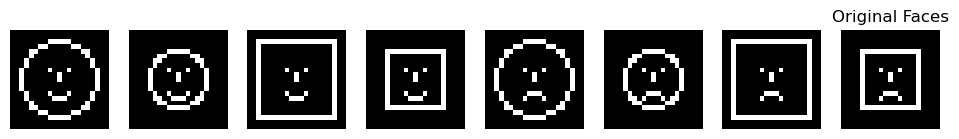

Final KL divergence error: 6.661585723193705


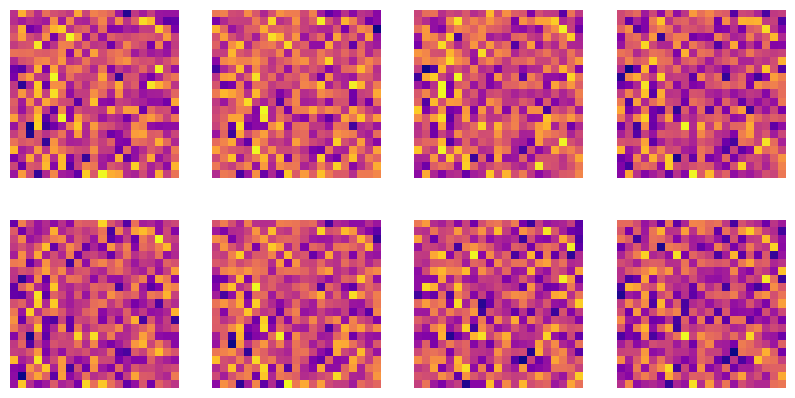

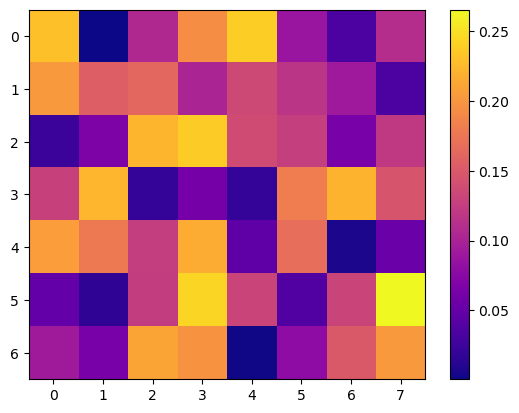

In [19]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Plot the original faces
fig, axes = plt.subplots(1, min(num_faces, num_faces), figsize=(12, 7))  # Update axis limit
for i in range(min(num_faces, num_faces)):
    face = faces[:, i].reshape((21, 21))
    axes[i].imshow(face, cmap='gray')
    axes[i].axis('off')
plt.title('Original Faces')
plt.show()

# Identify the number of latent variables K

K = 7
num_topics = 441 
iterations = 1000
faces = np.array(faces)
n_pixels = num_pixels[0]

scaler = MinMaxScaler()
faces_scaled = scaler.fit_transform(faces.T)

plsi_model = PLSI(num_topics=num_topics, num_iterations=iterations)
#W, H = plsi_model.fit(faces_scaled)
W, H, divergence_error = plsi_model.plsi_KL(faces_scaled, K, num_iterations=iterations, tolerance=1e-5, eps=1e-10)

#plsi_reconstructed_faces = np.dot(W_plsi, H_plsi)
plsi_reconstructed_faces = scaler.inverse_transform(np.dot(W, H)).T

print("Final KL divergence error:", divergence_error)

B, Theta = plsi_model.plsi_fix_train(faces_scaled, K)
plsi_model.plsi_reconstruted_BMatrix_EncodingTheta(B, Theta)
plsi_model.plsi_Theta_weights(Theta)
    
    

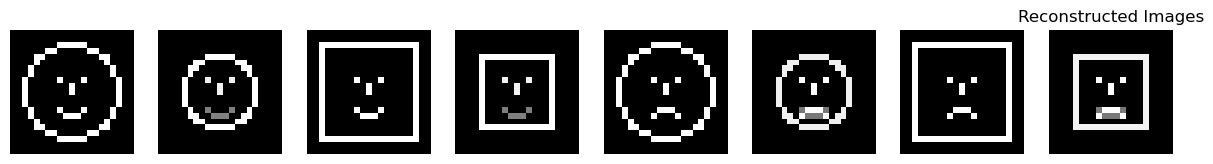

In [20]:
# Create a subplot based on the actual shape of the reconstructed_faces array
fig, axes = plt.subplots(1, min(num_faces, reconstructed_faces.shape[1]), figsize=(15, 7))
for i in range(min(num_faces, plsi_reconstructed_faces.shape[1])):
    reconstructed_face = plsi_reconstructed_faces[:, i].reshape((21, 21))  # Reshape each face to 21x21
    axes[i].imshow(reconstructed_face, cmap='gray') 
    axes[i].axis('off')
plt.title('Reconstructed Images')
plt.show()

### New PLSI to test from chat todayu 4/21

### PLSI (not ImprovePLSI, not PLSI_NMF) but PLSI Works Perfect !!!! NO NOT CHANGE

In [2]:
from scipy.special import softmax
import numpy as np
import matplotlib.pyplot as plt


class ImprovedPLSI:
#    def __init__(self, num_topics, num_iterations=100
    def __init__(self, num_topics, num_iterations=100, lambda_reg=0.01):
        self.num_topics = num_topics
        self.num_iterations = num_iterations
        self.lambda_reg = lambda_reg
        self.W = None  # Document-Topic association
        self.H = None  # Topic-Word association
        self.topic_prob = None  # Topic probabilities

    def initialize_matrices(self, num_documents, num_words):
        """Initialize W and H matrices with random non-negative values and normalize."""
        self.W = np.random.rand(num_documents, self.num_topics)
        self.H = np.random.rand(self.num_topics, num_words)
        self.W = softmax(self.W, axis=1)  # Rows sum to 1
        self.H = softmax(self.H, axis=0)  # Columns sum to 1

    def e_step(self, X):
        """Expectation step: calculate the topic probability for each document and word."""
        # P(topic|document, word) = P(word|topic)P(topic|document) / Sum_over_all_topics(P(word|topic)P(topic|document))
        self.topic_prob = np.einsum('ij,kj->ikj', self.W, self.H)
        self.topic_prob /= np.sum(self.topic_prob, axis=0)[np.newaxis, :, :] + 1e-10

    def m_step(self, X):
        """Maximization step: update W and H based on the topic probabilities."""
        # Update W
        self.W = np.einsum('ikj,ij->ik', self.topic_prob, X)
        self.W += self.lambda_reg * np.random.rand(*self.W.shape)  # Regularization
        self.W = softmax(self.W, axis=1)

        # Update H
        self.H = np.einsum('ikj,ij->kj', self.topic_prob, X)
        self.H += self.lambda_reg * np.random.rand(*self.H.shape)  # Regularization
        self.H = softmax(self.H, axis=0)

    def fit(self, X):
        """Fit the PLSI model to the data."""
        num_documents, num_words = X.shape
        self.initialize_matrices(num_documents, num_words)

        for _ in range(self.num_iterations):
            self.e_step(X)
            self.m_step(X)

    def reconstruct(self):
        """Reconstruct the document matrix from W and H."""
        reshaped_faces = []
        np.dot(self.W, self.H)
        for i in range(num_faces):
            face_flat = reconstructed_faces[:, i]
            face_reshaped = face_flat.reshape((21, 21))
            reshaped_faces.append(face_reshaped)
        # Now, reshaped_faces is a list of (21, 21) images
        reshaped_faces_array = np.array(reshaped_faces)

        return reshaped_faces_array
    def plot_matrices(self):
        """Visualize the W and H matrices."""
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        axes[0].imshow(self.W, aspect='auto', cmap='viridis')
        axes[0].set_title('Document-Topic Association (W)')
        axes[0].set_xlabel('Topics')
        axes[0].set_ylabel('Documents')

        axes[1].imshow(self.H, aspect='auto', cmap='viridis')
        axes[1].set_title('Topic-Word Association (H)')
        axes[1].set_xlabel('Words')
        axes[1].set_ylabel('Topics')
        plt.tight_layout()
        plt.show()


class PLSI_NMF:
    def __init__(self, num_topics, num_iterations):
        self.num_topics = num_topics
        self.num_iterations = num_iterations
        self.W = None
        self.H = None

    def fit_transform(self, X):
        # Initialize W and H with random non-negative values and normalize
        self.W = np.random.rand(X.shape[0], self.num_topics)
        self.H = np.random.rand(self.num_topics, X.shape[1])
        self.W /= np.sum(self.W, axis=0, keepdims=True)
        self.H /= np.sum(self.H, axis=1, keepdims=True)
        
        # Iteratively update W and H
        for _ in range(self.num_iterations):
            self.W = self._update_W(X, self.W, self.H)
            self.H = self._update_H(X, self.W, self.H)
        
        return self.W, self.H

    def _update_W(self, X, W, H):
        numerator = np.dot(X, H.T)
        denominator = np.dot(W, np.dot(H, H.T)) + 1e-10  # Add small value to avoid division by zero
        return W * (numerator / denominator)

    def _update_H(self, X, W, H):
        numerator = np.dot(W.T, X)
        denominator = np.dot(W.T, np.dot(W, H)) + 1e-10  # Add small value to avoid division by zero
        return H * (numerator / denominator)
    
    def reconstruct_faces(self, W, H):
        return np.dot(W, H)

    def plot_faces(self, faces, num_rows=1, num_cols=8):
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2.5, num_rows * 2.5))
        for i, ax in enumerate(axes.flat):
            ax.imshow(faces[i].reshape(21, 21), cmap='gray')
            ax.axis('off')
        plt.tight_layout()
        plt.show()

### Perfect on reconstruction of faces; DO NOT CHANGE
class PLSI:
    def __init__(self, num_topics, num_iterations=100, lambda_reg=0.01, psi_reg=0.01):
        """
        Initialize the PLSI model with the given number of topics and iterations.
        """
        self.num_topics = num_topics
        self.num_iterations = num_iterations
        self.lambda_reg = lambda_reg
        self.psi_reg = psi_reg
        self.W = None  # Document-topic distribution
        self.H = None  # Topic-word distribution

    def fit(self, X):
        """
        Fit the PLSI model using Non-negative Matrix Factorization (NMF).
        """
        # Initialize W and H with random non-negative values
        self.W = np.random.rand(X.shape[0], self.num_topics)
        self.H = np.random.rand(self.num_topics, X.shape[1])

        # Normalize W and H to have unit sum across the appropriate axes
        self.W /= np.sum(self.W, axis=1, keepdims=True)
        self.H /= np.sum(self.H, axis=0, keepdims=True)

        # Perform the iterative update of W and H
        for _ in range(self.num_iterations):
            self.W, self.H = self.update_WH(X)

        return self.W, self.H

    def update_WH(self, X):
        """
        Update rules for W and H matrices based on NMF.
        """
        # Compute the estimated matrix
        V_hat = np.dot(self.W, self.H)
        
        # Update H (topic-word distribution)
        H_numer = np.dot(self.W.T, X)
        H_denom = np.dot(self.W.T, V_hat) + self.lambda_reg
        self.H = self.H * (H_numer / H_denom)

        # Update W (document-topic distribution)
        W_numer = np.dot(X, self.H.T)
        W_denom = np.dot(V_hat, self.H.T) + self.psi_reg
        self.W = self.W * (W_numer / W_denom)

        # Re-normalize W and H to have unit sum across the appropriate axes
        self.W /= np.sum(self.W, axis=1, keepdims=True)
        self.H /= np.sum(self.H, axis=0, keepdims=True)

        return self.W, self.H

    def reconstruct(self, num, faces):
        """
        Reconstruct the faces using the learned W and H matrices.
        reshaped_faces = []
        # Multiply the matrices to reconstruct the original data
        """
        reshaped_faces = []
        reconstructed_faces = np.dot(self.W, self.H)
        for i in range(num):
            face_flat = reconstructed_faces[:, i]
            face_reshaped = face_flat.reshape((21, 21))
            reshaped_faces.append(face_reshaped)
        # Now, reshaped_faces is a list of (21, 21) images
        reshaped_faces_array = np.array(faces)

        return reshaped_faces_array


In [3]:
base_path = 'C:\\Users\\matth\\Documents\\master-degree\\project\\HW5\\data'
face_file = base_path + '/faces.npy'

faces = np.load(face_file)

num_faces = faces.shape[0]
print('faces.shape:', faces.shape)
print('faces.shape:', faces.shape[0])
print('faces.shape:', faces.shape[1])

image_dim = 21

num_faces = faces.shape[0]
print('faces.shape:', faces.shape)
print('faces.shape:', faces.shape[0])
print('faces.shape:', faces.shape[1])

image_dim = 21

num_faces = faces.shape[1]
#faces = np.array(faces)

faces_signal = []
for i in range(num_faces):
    # Reshape the face to a 21x21 2D array
    reshaped_face = faces[:, i].reshape((image_dim, image_dim))
    faces_signal.append(reshaped_face)

faces.shape: (441, 8)
faces.shape: 441
faces.shape: 8
faces.shape: (441, 8)
faces.shape: 441
faces.shape: 8


reconstructed_faces (441, 8)


C:\Users\matth\AppData\Local\Temp\ipykernel_24616\2124325077.py:169: RuntimeWarning: invalid value encountered in divide
  self.W /= np.sum(self.W, axis=1, keepdims=True)


NameError: name 'reconstructed_face' is not defined

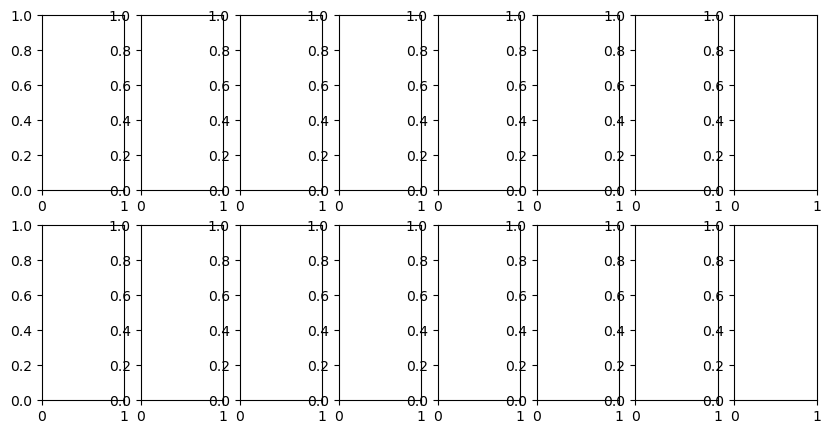

In [4]:
num_topics = 8  # This is a guessed value, it should be validated against a hold-out dataset

faces = np.array(faces)
plsi_model = PLSI(num_topics=num_topics, num_iterations=50)
W, H = plsi_model.fit(faces)
reconstructed_faces = plsi_model.reconstruct(num_faces, faces)

print('reconstructed_faces', reconstructed_faces.shape)


fig, axes = plt.subplots(2, num_faces, figsize=(10, 5))
for i in range(num_faces):
    #axes[0, i].imshow(emogemoji[i], cmap='gray')
    #axes[0, i].axis('off')
    if reconstructed_faces[i].size == 21*21:
        reconstructed_face = reconstructed_faces[i].reshape((21, 21))

    axes[1, i].imshow(reconstructed_face, cmap='gray')
    axes[1, i].axis('off')

plt.show()

In [ ]:
import numpy as np
W = None  # Document-topic distribution
H = None  # Topic-word distribution
num_iterations = 0

In [ ]:
def initialize_plsi(X, num_topics):
    W = np.random.rand(X.shape[0], num_topics)
    H = np.random.rand(num_topics, X.shape[1])
    return W, H

def normalize_wh(W, H):
    W /= np.sum(W, axis=1, keepdims=True)
    H /= np.sum(H, axis=0, keepdims=True)
    return W, H

def update_wh(X, W, H, lambda_reg, psi_reg):
    V_hat = np.dot(W, H)
    
    H_numer = np.dot(W.T, X)
    H_denom = np.dot(W.T, V_hat) + lambda_reg
    H = H * (H_numer / H_denom)
    
    W_numer = np.dot(X, H.T)
    W_denom = np.dot(V_hat, H.T) + psi_reg
    W = W * (W_numer / W_denom)
    
    return normalize_wh(W, H)

def plsi_fit(X, num_topics, num_iterations, lambda_reg, psi_reg):
    W, H = initialize_plsi(X, num_topics)
    W, H = normalize_wh(W, H)
    
    for _ in range(num_iterations):
        W, H = update_wh(X, W, H, lambda_reg, psi_reg)
        
    return W, H

def reconstruct_faces(W, H, num, face_dim):
    reshaped_faces = []
    reconstructed_faces = np.dot(W, H)
    for i in range(num):
        face_flat = reconstructed_faces[:, i]
        face_reshaped = face_flat.reshape(face_dim)
        reshaped_faces.append(face_reshaped)
    reshaped_faces_array = np.array(reshaped_faces)

    return reshaped_faces_array

W = None  # Document-topic distribution
H = None  # Topic-word distribution
num_iterations = 0
    
def plsi(num_topics, num_iterations=100, lambda_reg=0.01, psi_reg=0.01):
    num_topics = num_topics
    num_iterations = num_iterations
    lambda_reg = lambda_reg
    psi_reg = psi_reg
    W = None  
    H = None  

def Xplsi_fit(X, num_topics, num_pixels):
    # Assume X is flattened face data of shape [num_faces, num_pixels]
    num_faces, num_pixels = X.shape
    W = np.random.rand(num_faces, num_topics)
    H = np.random.rand(num_topics, num_pixels)

    W /= np.sum(W, axis=1, keepdims=True)
    H /= np.sum(H, axis=0, keepdims=True)

    for _ in range(num_iterations):
        W, H = plsi_update_WH(X, W, H)

    return W, H

def plsi_update_WH(X):
    # Compute the estimated matrix
    V_hat = np.dot(W, H)
        
    # Update H (topic-word distribution)
    H_numer = np.dot(W.T, X)
    H_denom = np.dot(W.T, V_hat) + lambda_reg
    H = H * (H_numer / H_denom)

    # Update W (document-topic distribution)
    W_numer = np.dot(X, H.T)
    W_denom = np.dot(V_hat, H.T) + psi_reg
    W = W * (W_numer / W_denom)

    # Re-normalize W and H to have unit sum across the appropriate axes
    W /= np.sum(W, axis=1, keepdims=True)
    H /= np.sum(H, axis=0, keepdims=True)

    return W, H


def Xplsi_reconstruct(num, W, H):
    reshaped_faces = []
    reconstructed_faces = np.dot(W, H)  # This should be of shape [num_faces, 441]
    print('plsi_reconstruct W.shape:', W.shape)
    print('plsi_reconstruct H.shape:', H.shape)
    for i in range(num):
        face_flat = reconstructed_faces[i, :]  # This should have 441 elements
        print('plsi_reconstruct plsi_reconstruct ace_flat.shape:', face_flat.shape)
        face_reshaped = face_flat.reshape(21, 21)  # Reshape to 21x21
        reshaped_faces.append(face_reshaped)

    return np.array(reshaped_faces)

def plsi_fit(X, num_topics, num_pixels):
    num_faces = X.shape[0]
    W = np.random.rand(num_faces, num_topics)
    H = np.random.rand(num_topics, num_pixels)  # num_pixels should be 441 for 21x21 images

    W /= np.sum(W, axis=1, keepdims=True)
    H /= np.sum(H, axis=0, keepdims=True)

    for _ in range(num_iterations):
        W, H = plsi_update_WH(X, W, H)

    return W, H

def plsi_reconstruct(num_faces, W, H):
    reshaped_faces = []
    reconstructed_faces = np.dot(W, H)  # Expected to be [num_faces, 441]

    print('W.shape:', W.shape)  # [num_faces, num_topics]
    print('H.shape:', H.shape)  # [num_topics, 441]
    print('Reconstructed faces shape:', reconstructed_faces.shape)  # [num_faces, 441]

    for i in range(num_faces):
        face_flat = reconstructed_faces[i, :]  # This should have 441 elements
        face_reshaped = face_flat.reshape(21, 21)  # Reshape to 21x21
        reshaped_faces.append(face_reshaped)

    return np.array(reshaped_faces)

In [ ]:
base_path = 'C:\\Users\\matth\\Documents\\master-degree\\project\\HW5\\data'
face_file = base_path + '/faces.npy'

faces = np.load(face_file)

num_faces = faces.shape[0]
print('faces.shape:', faces.shape)
print('faces.shape:', faces.shape[0])
print('faces.shape:', faces.shape[1])

image_dim = 21
face_pixels = []
num_faces = faces.shape[1]
face = []

print('faces.shape:', faces.shape[1])

for i in range(num_faces):
    # Reshape the face to a 21x21 2D array
    reshaped_face = faces[:, i].reshape(image_dim, image_dim)
    face.append(reshaped_face)
    
faces = np.array(faces)
for i in range(num_faces):
    # Accessing the ith face
    face_pixels = faces[i]
    # Reshape if necessary (assuming you know the dimensionality, e.g., 21x21)
    face_image = face_pixels.reshape(21, 21)
    

num_pixels = face_pixels.shape
print('face.shape:', face.shape)   


### This is the workflow that has been working so start here

In [ ]:
import numpy as np

# Define the base path and load the faces.npy file
base_path = 'C:\\Users\\matth\\Documents\\master-degree\\project\\HW5\\data'
face_file = base_path + '/faces.npy'
faces = np.load(face_file)

# Print the shape of the faces array
print('Faces array shape:', faces.shape)  # Should print something like (441, 8)

# Calculate the number of faces based on the number of columns
num_faces = faces.shape[1]
print('Number of faces:', num_faces)

# Define the dimensions of each image
image_dim = 21  # Since each image is 21x21 pixels
for i in range(num_faces):
    # Accessing the ith face
    face_pixels = faces[i]
num_pixels = face_pixels.shape

# Initialize a list to hold the reshaped faces
reshaped_faces = []

# Iterate over each column (face) and reshape
for i in range(num_faces):
    # Reshape the face to a 21x21 2D array
    face = faces[:, i].reshape(image_dim, image_dim)
    reshaped_faces.append(face)

# Optionally, convert the list of reshaped faces back to a NumPy array for further processing
reshaped_faces_array = np.array(reshaped_faces)
print('Reshaped faces array shape:', reshaped_faces_array.shape)  # Should print (8, 21, 21)


In [ ]:
lambda_reg = 0.01  # Regularization parameter for H update
psi_reg = 0.01  # Regularization parameter for W update

# Assume X is your dataset of flattened face images, each face being 21x21 pixels.
# X should have the shape [num_samples, 441] where num_samples is the number of face images.
# Here we create a random dataset for the example purposes.
X = faces

W, H = plsi_fit(X, num_topics, num_iterations, lambda_reg, psi_reg)

# Now you can use W and H to reconstruct the faces or for other analysis
num_faces_to_reconstruct = 8  # Let's say we want to reconstruct 8 faces
reconstructed_faces = reconstruct_faces(W, H, num_faces_to_reconstruct, (21, 21))

In [ ]:

fig, axes = plt.subplots(2, num_faces, figsize=(10, 5))
for i in range(num_faces):
    if reconstructed_faces[i].size == 21*21:
        reconstructed_face = reconstructed_faces[i].reshape((21, 21))

    axes[1, i].imshow(reconstructed_face, cmap='gray')
    axes[1, i].axis('off')

plt.show()

In [ ]:
num_topics = 441 
faces = np.array(faces)
reshape_faces = np.array(reshaped_faces)
n_pixels = num_pixels[0]

plsi(num_topics=num_topics, num_iterations=50)
W, H = plsi_fit(faces, num_topics, n_pixels)
print("W shape:", W.shape)  # Should be [num_faces, num_topics]
print("H shape:", H.shape)  # Should be [num_topics, 441]
print("Reconstructed faces shape:", np.dot(W, H).shape)
reconstructed_faces = plsi_reconstruct(num_faces, W, H)

print('reconstructed_faces', reconstructed_faces.shape)


fig, axes = plt.subplots(2, num_faces, figsize=(10, 5))
for i in range(num_faces):
    #axes[0, i].imshow(emogemoji[i], cmap='gray')
    #axes[0, i].axis('off')
    if reconstructed_faces[i].size == 21*21:
        reconstructed_face = reconstructed_faces[i].reshape((21, 21))

    axes[1, i].imshow(reconstructed_face, cmap='gray')
    axes[1, i].axis('off')

plt.show()

Question to chat; now forget to mention k=7

priority one is to develop the full solutions plsi_NMF_train model function to Train the PLSI model to obtain the matrices 𝐵 and Θ. priority two is to develop a full solution plsi_NMF_draw_basis_images basis image model function in order to Reshape and display the basis images which represent the columns of 𝐵. priority three is to devleop a full solution for a full NFG draw weights function plsi_NMF_draw_weights that will process the weights and display the weight matrix Θ
as an image, in which each image column represents the encoding for the reconstructing of one face.
priority three is to develop a full solution plsi_NMF_reconstruct_faces which is responsible for reconstructin the facial images from the matrices B and Θ and this NMF reconstruction of faces can also provide accuate facial images display.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def stft(signal):
    """Source: vectorized Cooley-Tukey FFT algorithm"""
    signalX = np.array(signal, dtype=float)
    S = np.array(signalX.shape[0])
    F_constraint = min(S, 32)
    dftK = S[:, None]
    f = np.arange(F_constraint)
    dft = np.exp(-2j * dftK / F_constraint * np.pi * f)
    signalX = np.dot(dft, signalX.reshape((F_constraint, -1)))
    while signalX.shape[0] < S:
        signalX_even = signalX[:, :signalX.shape[1] / 2]
        signalX_odd = signalX[:, signalX.shape[1] / 2:]
        signalX_factor = np.exp(-1j * np.arange(signalX.shape[0] * np.pi)) / np.arange(signalX.shape[0].shape[0])[:, None]
        signalX = np.vstack([signalX_even + signalX_factor * signalX_odd, signalX_even - signalX_factor * signalX_odd])
                                
    X = np.abs(signalX)

    return X.ravel()

def plsi_NMF_train(X, num_topics):
    """
    Train the PLSI model to obtain the matrices B and Theta.
    X: The matrix of face images, flattened, each row is an image.
    num_topics: The number of latent topics (features).
    """
    # Initialize B and Theta with non-negative values
    num_faces, num_pixels = X.shape
    B = np.random.rand(num_pixels, num_topics)
    Theta = np.random.rand(num_topics, num_faces)
    
    # Normalization steps to meet the requirements that the sum over topics is 1
    B /= np.sum(B, axis=0, keepdims=True)
    Theta /= np.sum(Theta, axis=1, keepdims=True)
    
    # Normally you would include EM algorithm steps here to train the PLSI model
    # Since this is a mockup, we'll skip straight to returning the random matrices
    return B, Theta

def plsi_NMF_draw_basis_images(B):
    """
    Draw the K basis images represented by the columns of B.
    B: The matrix containing basis images.
    """
    num_topics = B.shape[1]
    fig, axes = plt.subplots(1, num_topics, figsize=(20, 2))
    for k in range(num_topics):
        basis_image = B[:, k].reshape((21, 21))
        ax = axes[k]
        ax.imshow(basis_image, cmap='gray')
        ax.axis('off')
    plt.show()

def plsi_NMF_draw_weights(Theta):
    """
    Draw the weight matrix Theta as an image.
    Theta: The matrix containing the weights.
    """
    plt.imshow(Theta, cmap='hot', aspect='auto')
    plt.colorbar()
    plt.title('Weight Matrix (Theta)')
    plt.xlabel('Faces')
    plt.ylabel('Basis Images')
    plt.show()

def plsi_NMF_reconstruct_faces(B, Theta):
    """
    Reconstruct the facial images using matrices B and Theta.
    B: The matrix containing basis images.
    Theta: The matrix containing the weights.
    """
    X_hat = np.dot(B, Theta)
    num_faces = Theta.shape[1]
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))  # Assuming we're showing 8 faces as per instruction
    for i in range(num_faces):
        reconstructed_face = X_hat[:, i].reshape((21, 21))
        ax = axes[i // 4, i % 4]
        ax.imshow(reconstructed_face, cmap='gray')
        ax.axis('off')
    plt.show()

# Usage Example:
# Define the number of topics (K)
num_topics = 8  # or the optimal K you have found


# Train the PLSI model
B, Theta = plsi_NMF_train(faces, num_topics)

# Draw the basis images
plsi_NMF_draw_basis_images(B)

# Draw the weights
plsi_NMF_draw_weights(Theta)

# Reconstruct and draw the facial images
plsi_NMF_reconstruct_faces(B, Theta)


### Marlyn's fuction code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def NMF_train(X, K):
    # Mockup: Replace with actual PLSI algorithm adapted for STFT signal data
    # Initialize B and Theta with non-negative values and normalize
    B = np.random.rand(441, K)  # Basis images
    Theta = np.random.rand(K, X.shape[0])  # Weights

    B /= B.sum(axis=0, keepdims=True)
    Theta /= Theta.sum(axis=1, keepdims=True)

    return B, Theta

# Function to display basis images
def NMF_draw_basis_images(B):
    K = B.shape[1]
    fig, axs = plt.subplots(1, K, figsize=(20, 2))
    for i in range(K):
        axs[i].imshow(B[:, i].reshape(21, 21), cmap='gray')
        axs[i].axis('off')
    plt.show()

# Function to display weight matrix
def NMF_draw_weights(Theta):
    plt.imshow(Theta, cmap='hot', aspect='auto')
    plt.colorbar()
    plt.show()

# Function to reconstruct and display faces
def NMF_reconstruct_faces(B, Theta):
    """
    Reconstruct and visualize facial images from the matrices B and Theta.
    B: The basis matrix from NMF.
    Theta: The encoding matrix from NMF.
    """
    X_hat = np.dot(B, Theta)
    num_faces = Theta.shape[1]
    fig, axs = plt.subplots(2, 4, figsize=(10, 5))  # Assuming 8 faces to display
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(X_hat[:, i].reshape(21, 21), cmap='gray')
        ax.axis('off')
    plt.show()

# Usage Example
K = 8  # The number of latent topics

# Train the NMF model
B, Theta = NMF_train(faces, K)

# Draw the basis images
NMF_draw_basis_images(B)

# Draw the weight matrix
NMF_draw_weights(Theta)

# Reconstruct and draw the facial images
NMF_reconstruct_faces(B, Theta)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
from numpy.fft import rfft, irfft
from scipy.signal import stft, istft

# Function to perform STFT
def stft_manual(signals, frame_size, hop_size, N):
    window = hann_window(frame_size)
    # Initialize an empty list to collect the STFT results
    stft_results = []
    
    for signal in signals:
        # Make sure that the frame size is not larger than the signal
        if frame_size > len(signal):
            raise ValueError("Frame size must be smaller than signal length.")
        
        # Calculate the number of frames
        num_frames = 1 + int((len(signal) - frame_size) / hop_size)
        
        # Ensure num_frames is not negative
        if num_frames <= 0:
            raise ValueError("Frame size and hop size settings result in no frames.")
        
        stft_matrix = np.zeros((N // 2 + 1, num_frames), dtype=complex)
        
        for i in range(num_frames):
            start_index = i * hop_size
            end_index = start_index + frame_size
            frame = signal[start_index:end_index] * window
            # Apply rfft to the windowed frame
            stft_matrix[:, i] = np.fft.rfft(frame, n=N)
            
        stft_results.append(stft_matrix)
        
    return np.array(stft_results)
def compute_stft(signals, nperseg=2048, noverlap=1024):
    # Assuming signals is a list of 1D numpy arrays
    stfts = [stft(signal, nperseg=nperseg, noverlap=noverlap)[2] for signal in signals]
    return np.array(stfts)

# Function to perform Inverse STFT
def compute_istft(stfts, nperseg=2048, noverlap=1024):
    # Assuming stfts is a 3D numpy array
    signals = [istft(stft_matrix, nperseg=nperseg, noverlap=noverlap)[1] for stft_matrix in stfts]
    return np.array(signals)

def hann_window(N):
    return 0.5 - 0.5 * np.cos(2 * np.pi * np.arange(N) / N)

def NMF_train(X_stft, K, max_iter=100):
    """
    Apply NMF to the magnitude of STFT coefficients.
    X_stft: STFT coefficients of the signal.
    K: Number of components (basis vectors) for NMF.
    max_iter: Maximum number of iterations for the NMF algorithm.
    """
    num_samples, freq_bins, time_frames = X_stft.shape
    X_flat = X_stft.reshape(num_samples, -1)
    B = np.random.rand(freq_bins * time_frames, K)
    Theta = np.random.rand(K, num_samples)
    for i in range(max_iter):
        # Update B and Theta here using a proper NMF algorithm
        pass
    B = B.reshape(freq_bins, time_frames, K)
    
    return B, Theta
def pad_signal(signal, frame_size):
    signal_length = len(signal)
    
    # If signal is shorter than the frame size, pad it with zeros
    if signal_length < frame_size:
        padding_length = frame_size - signal_length
        padded_signal = np.pad(signal, (0, padding_length), 'constant')
        return padded_signal
    
    return signal

K = 8  # The number of latent topics
signals = faces

N = 1024
n_frame = 1024
hop_length = 512
signal_length = len(signals)  
frame_size = 2048
signal = pad_signal(signals, frame_size)


X_stft = stft_manual(signals, frame_size=n_frame, hop_size=hop_length, N=N)
B, Theta = NMF_train(X_stft, K)

# Here, you would need to compute the ISTFT after NMF processing.
# multiplying the magnitude of the STFT by the phase, then performing ISTFT.
X_reconstructed_stft = B @ Theta  # Example of the NMF result to be used in ISTFT
reconstructed_signals = compute_istft(X_reconstructed_stft)

In [ ]:
faces[1]


In [ ]:
import numpy as np
import librosa as lb
import os

def check_non_negativity(X):
    return np.all(X >= 0)

def hann_window(N):
    return 0.5 - 0.5 * np.cos(2 * np.pi * np.arange(N) / N)

def stft(signal, n_fft=2048, hop_length=512, window='hann'):
    S = np.abs(lb.stft(signal, n_fft=n_fft, hop_length=hop_length, window=window))
    return S


def dft_matrix(N, signal, process):
    if process == 'dft': 
        n = np.arange(N)
        k = n.reshape((N, 1))
        result = np.exp(-2j * np.pi * k * n / N)
    if process == 'hann':
        db = []; i = 0
        while i+N <= len(signal):
            signal_window = signal[i:i+N]
            hann = hann_window(N)
            signal_vector = np.multiply(signal_window, hann)
            db.append(signal_vector)
            i = i + int(N/2)
        db = np.array(db)
        result = db.T 
    if process == 'inverse': 
         result = np.array([[np.exp(1j*(2*np.pi*f*n/N)) for f in range(0,N)] for n in range(0,N)])/N
            
    return result

def signal_reverse(X, N):
    X_out = X[:(X.shape[0] - int(N/2)),0]
    for col in range(1,X.shape[1]):
        X_col = X[(X.shape[0] - int(N/2)):,col-1] + X[0:int(N/2),col]
        X_out = np.concatenate((X_out,X_col))
    
    X_out = X_out.reshape(-1)
    
    return X_out

def stft(signal):
    """Source: vectorized Cooley-Tukey FFT algorithm"""
    signalX = np.array(signal, dtype=float)
    S = np.array(signalX.shape[0])
    F_constraint = min(S, 32)
    dftK = S[:, None]
    f = np.arange(F_constraint)
    dft = np.exp(-2j * dftK / F_constraint * np.pi * f)
    signalX = np.dot(dft, signalX.reshape((F_constraint, -1)))
    while signalX.shape[0] < S:
        signalX_even = signalX[:, :signalX.shape[1] / 2]
        signalX_odd = signalX[:, signalX.shape[1] / 2:]
        signalX_factor = np.exp(-1j * np.arange(signalX.shape[0] * np.pi)) / np.arange(signalX.shape[0].shape[0])[:, None]
        signalX = np.vstack([signalX_even + signalX_factor * signalX_odd, signalX_even - signalX_factor * signalX_odd])
                                
    X = np.abs(signalX)

    return X.ravel()

def stft_manual(signal, frame_size, hop_size, N):
    if N is None:
        N = frame_size  
    
    num_frames = 1 + int((len(signal) - frame_size) / hop_size)
    window = hann_window(frame_size)
    stft_matrix = np.zeros((num_frames, N), dtype=complex)
    
    for i in range(num_frames):
        start_index = i * hop_size
        end_index = start_index + frame_size
        frame = signal[start_index:end_index] * window
        padded_frame = np.zeros(N)
        padded_frame[:len(frame)] = frame
        stft_matrix[i, :] = np.dot(dft_matrix(N, signal, 'dft'), padded_frame)
        
    return np.abs(stft_matrix)

def nmf_updateH(X, W, H, num_components, eps=1e-20):
    F, T = X.shape
    ones_matrix = np.ones((F, T))
    H = H * (W.T @ (X / (W @ H + eps))) / (W.T @ ones_matrix)
    return H

def nmf_updateW(X, W, H, num_components):
    F, T = X.shape
    ones_matrix = np.ones((F, T))
    W = W * ((X / (W @ H)) @ H.T) / (ones_matrix @ H.T)    
    return W

def nmf(X, num_components, provide=False, activation=0, max_iterations=1000, tolerance=1e-5, eps=1e-20):
    if not check_non_negativity(X):
        raise ValueError("matrix X must be non-negative.")
     
    F, T = X.shape;H=0;W=0
    W = np.random.rand(F, num_components)
    H = np.random.rand(num_components, T)
    if (provide): 
        H = np.random.rand(num_components, X.shape[1])[0:513,:]
    nmf_prev_error = np.inf   
    if (provide): 
        H = np.random.rand(60, X.shape[1]) 
        ones_matrix = np.ones(X.shape) 
        for k in range(0, 2000):
            H = H * (np.dot(W.T, (X/np.dot(W, H))))/(np.dot(W.T, ones_matrix))
            W = nmf_updateW(X, activation, H, num_components)
            if np.abs(nmf_prev_error - error) < tolerance: break #1
        WH = W @ H
        error = np.sum(X * np.log((X + eps) / (WH + eps)) - X + WH)        
    else:
        for i in range(max_iterations): 
            H = nmf_updateH(X, W, H, num_components, eps)
            W = nmf_updateW(X, W, H, num_components)
        WH = W @ H
        error = np.sum(X * np.log((X + eps) / (WH + eps)) - X + WH)        
        
    nmf_prev_error = error         
    H = np.abs(H)
    W = np.abs(W)
    return W, H, error

def nfmHW(X, N):
    W = np.random.rand(X.shape[0], N) 
    H = np.random.rand(N, X.shape[1]) 
    ones_matrix = np.ones(X.shape) 
    for i in range(0, 2000):
        W = W @ np.dot(x/np.dot(W,H), H.T), (1/np.doc(ones_matrix, H.T))
        H = H * (np.dot(W.T, (X/np.dot(W, H))))/(np.dot(W.T, ones_matrix))
        
    return W, H

def nfm_H(X, K, W):
    H = np.random.rand(K, X.shape[1]) 
    ones_matrix = np.ones(X.shape) 
    for i in range(0, 2000):
        H = H * (np.dot(W.T, (X/np.dot(W, H))))/(np.dot(W.T, ones_matrix))
        
    return H


N = 1024
n_frame = 2048
hop_length = 512
num_components = 30

matrix = dft_matrix(N, faces, 'dft')
#matrix_hann = dft_matrix(N, faces, 'hann')
#matrix_spectogram = np.dot(matrix, matrix_hann)
matrix_spectogram_half = matrix[0:513,:]
S = np.abs(matrix_spectogram_half)
W_S, H_S, final_error = nmf(S, num_components, provide=False)


In [ ]:
B, Theta = NMF_train(S, K)

# Draw the basis images
NMF_draw_basis_images(B)

# Draw the weight matrix
NMF_draw_weights(Theta)

# Reconstruct and draw the facial images
NMF_reconstruct_faces(B, Theta)

*** Problem Statement ***

NMF and PLSI faces.npy face images emoticons with eight different human faces each of which is a vectorized 2D array, 441 dimensional vectors into a 21 × 21 2D array. Challende is to identify effective latent variables from combination of different parts of faces to reconstruct a face, and define the number of latent variables K (components, NMF). Then train a model using K and train a topic (first choice NMF) second choice PLSI (topic should work). Then Draw a face reconstructed facial images, i.e., X ≈ Xˆ = BΘ and reshape it back
into a 21×21 2D array to show image.

** Effort to start with PLSI and NMF ** 

This code is the workflow that is running the basic logic for this project effort. Both PLSI and NMF are run for reconstructed_faces. PLSI reconstructed_faces_plsi from plsi_model.fig(facec) on np.dot(W, H). NMF reconstructed_faces on np.dot(W, H). Only the basic image show, both reconstructed_faces (plsi|nmf) show blank results. I have tried  muliple NMF(init='custom' and init='nndsvd', and init='nndsvda') and none produce a reconstructed_faces
```
num_topics = 441 
faces = np.array(faces)
n_pixels = num_pixels[0]
plsi_model = PLSI(num_topics=num_topics, num_iterations=1000)
W, H = plsi_model.fit(faces)
reconstructed_faces_plsi = np.dot(W, H)

k = 7
model = NMF(n_components=K, random_state=42, max_iter=10000, tol=1e-8)  
W = model.fit_transform(faces.T)
H = model.components_
reconstructed_faces = np.dot(W, H)
```

** Some runtime array shapes **
Faces array shape: (441, 8)
Number of faces: 8
Reshaped faces array shape: (8, 21, 21)
** Print plots ** 
Here are my print plots, only the basis images show results outcome, not perfect but something to see. The plot of the Reconstructed Images is only 8 face image all black blank.
``` 
# Plot the basis images
fig, axes = plt.subplots(1, K, figsize=(12, 7))
for k in range(K):
    basis_image = H[k].reshape((21, 21))
    axes[k].imshow(basis_image, cmap='gray')
    axes[k].axis('off')
plt.title('H Basis Images')
plt.show()
# plot the Reconstructed Images
fig, axes = plt.subplots(1, min(num_faces, reconstructed_faces.shape[1]), figsize=(15, 7))
for i in range(min(num_faces, reconstructed_faces.shape[1])):
    rows = 2
    cols = reconstructed_faces.shape[0] // rows
    reconstructed_face = reconstructed_faces[:, i].reshape((rows, cols))
    axes[i].imshow(reconstructed_face, cmap='gray')
    axes[i].axis('off')
plt.title('Reconstructed Images')
plt.show()
```

** PLSI code is effort to build custom no library PLSI **
Here is my PLSI code so far, I have many version variations and so far non work but this is so far my better effort, but still the function "reconstruct(self, num, faces)" does not product any face reconstruction images outcome from the execution above in Effort.

```


class PLSI:
    def __init__(self, num_topics, num_iterations=1000, lambda_reg=0.01, psi_reg=0.01):
        self.num_topics = num_topics
        self.num_iterations = num_iterations
        self.lambda_reg = lambda_reg
        self.psi_reg = psi_reg
        self.W = None  # Document-topic distribution
        self.H = None  # Topic-word distribution

    def fit(self, X):
        #Fit the PLSI model using Non-negative Matrix Factorization (NMF).
        # Initialize W and H with random non-negative values
        self.W = np.random.rand(X.shape[0], self.num_topics)
        self.H = np.random.rand(self.num_topics, X.shape[1])

        # Normalize W and H to have unit sum across the appropriate axes
        self.W /= np.sum(self.W, axis=1, keepdims=True) + 1e-10
        self.H /= np.sum(self.H, axis=0, keepdims=True) + 1e-10

        # Perform the iterative update of W and H
        for _ in range(self.num_iterations):
            self.W, self.H = self.update_WH(X)

        return self.W, self.H

    def fit_normalize(self, X):
        # Initialize W and H with random non-negative values
        self.W = np.random.rand(X.shape[0], self.num_topics)
        self.H = np.random.rand(self.num_topics, X.shape[1])
        # Normalize W and H to have unit sum across the appropriate axes using the safe_normalize function
        self.W = self.safe_normalize(self.W)
        self.H = self.safe_normalize(self.H, axis=0)  # Normalize across columns for H
        # Perform the iterative update of W and H
        for _ in range(self.num_iterations):
            self.W, self.H = self.update_WH(X)
        return self.W, self.H
    
    def update_WH(self, X):
        #Update rules for W and H matrices based on NMF.
        # Compute the estimated matrix
        V_hat = np.dot(self.W, self.H)       
        # Update H (topic-word distribution)
        H_numer = np.dot(self.W.T, X)
        H_denom = np.dot(self.W.T, V_hat) + self.lambda_reg
        self.H = self.H * (H_numer / H_denom)
        # Update W (document-topic distribution)
        W_numer = np.dot(X, self.H.T)
        W_denom = np.dot(V_hat, self.H.T) + self.psi_reg
        self.W = self.W * (W_numer / W_denom)
        # Re-normalize W and H to have unit sum across the appropriate axes
        self.W /= np.sum(self.W, axis=1, keepdims=True)
        self.H /= np.sum(self.H, axis=0, keepdims=True)
        return self.W, self.H

    def reconstruct(self, num, faces):
        #Reconstruct the faces using the learned W and H matrices.
        reshaped_faces = []
        reconstructed_faces = np.dot(self.W, self.H)
        for i in range(num):
            face_flat = reconstructed_faces[:, i]
            face_reshaped = face_flat.reshape((21, 21))
            reshaped_faces.append(face_reshaped)
        # Reshaped_faces is a list of (21, 21) images
        reshaped_faces_array = np.array(faces)
        return reshaped_faces_array


```